https://www.kaggle.com/c/dont-overfit-ii

https://www.kaggle.com/artgor/how-to-not-overfit

### Imports

In [35]:
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics

import xgboost as xgb
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

# Data Preparation

### Load Data

In [36]:
df_raw = pd.read_csv('./data/train.csv', header=0)
df_raw.drop(columns=['id'], inplace=True)
print('Dataframe shape is: ', df_raw.shape)
print('Columns are: ', df_raw.columns)
df_raw.head()

Dataframe shape is:  (250, 301)
Columns are:  Index(['target', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '290', '291', '292', '293', '294', '295', '296', '297', '298', '299'],
      dtype='object', length=301)


,target,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,-0.443,...,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,0.557,...,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,-0.624,...,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,-0.118,...,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,-0.656,...,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


In [37]:
#Inspect data for NaN.
print(list(df_raw.isna().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Create Correlation matrix and select the top most relevant features

In [38]:
#correlation matrix
corrmat = df_raw.corr()

(10.0, 0.0)

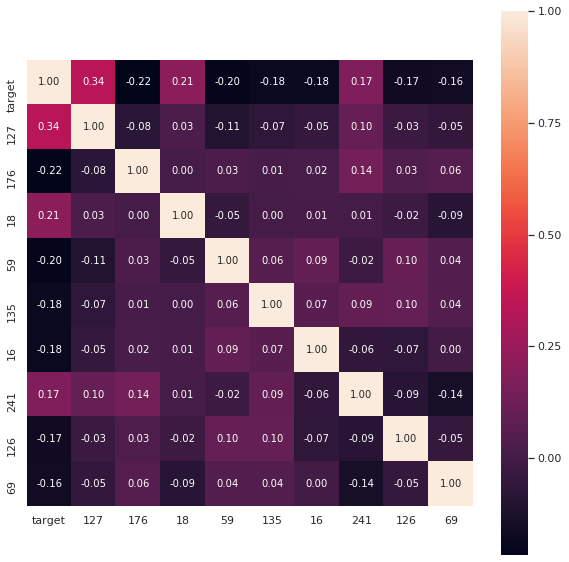

In [39]:
k = 10 #number of variables for heatmap
fig, ax = plt.subplots(figsize=(10, 10))
cols = np.absolute(corrmat).nlargest(k, 'target')['target'].index
cm = np.corrcoef(df_raw[cols].values.T)
sns.set(font_scale=1.)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values, ax=ax)

#Fix first and last rows. (Bug in recent matplotlib)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [40]:
k = 30
cols = np.absolute(corrmat).nlargest(k, 'target')['target'].index

In [41]:
df = df_raw[cols]

### Univariate distributions

In [42]:
#sns.set(font_scale=1.)
#hist = df.hist(bins=20, figsize=(12,20), layout=(5,5))

### Bivariate Distribution

In [43]:
#Make a Cornerplot of 10 of the most correlated features.
#sns.set(font_scale=1.)
#g = sns.pairplot(df.iloc[:,0:10])

In [44]:
# Remove one potential outlier.
print(df.shape)
df = df.drop(df[(df['69'] > 4)].index)
print(df.shape)

(250, 30)
(249, 30)


In [45]:
#Make a Cornerplot of the remaining 10 of the most correlated features.
#sns.set(font_scale=1.)
#g = sns.pairplot(df.iloc[:,10:])

In [46]:
# Remove one potential outlier.
print(df.shape)
df = df.drop(df[(df['133'] > 3.8)].index)
print(df.shape)

(249, 30)
(248, 30)


### Transform features whose distribution is highly skewed

In [47]:
numeric_feats = df.iloc[:,1:].dtypes[df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df.iloc[:,1:][numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
63,0.286141
177,0.251833
175,0.216192
167,0.165327
59,0.139561
127,0.115951
133,0.112376
135,0.089007
74,0.088164
241,0.085918


In [48]:
#Apply a log (1 + x) in the highly skewed features
def apply_log1p(_df):

    numeric_features = _df.iloc[:,1:].dtypes[_df.dtypes != 'object'].index

    # Check the skew of all numerical features
    skewed_features = _df.iloc[:,1:].apply(
      lambda x: skew(x.dropna())).sort_values(ascending=False)

    skewness = pd.DataFrame({'Skew': skewed_features})
    skewness = skewness[abs(skewness.values) > .75]

    skewed_features = skewness.index
    for feature in skewed_features:
        print('Transforming feature %s' %feature)
        _df[feature] = np.log1p(_df[feature])
    return _df

df = apply_log1p(df)

### Split sample

In [49]:
y = df['target'].values
df.drop(['target'], axis=1, inplace=True)
X = df.values
Train_X, Test_X, Train_y, Test_y = train_test_split(X, y, test_size=0.2, random_state=0)

### Metric Function

In [50]:
#Validation function
n_folds = 5

def acc_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=1).get_n_splits(Train_X)
    acc = cross_val_score(model, Train_X, Train_y, scoring='accuracy', cv=kf)
    return(acc)

### Optimize models

In [51]:
#SVM
from sklearn.svm import SVC

tuned_parameters = [
  {'kernel':['rbf'], 'gamma': np.logspace(-4,-1,5), 'C':np.logspace(-3,2,20)},
  {'kernel':['linear'], 'C':np.logspace(-3,2,20)},
  {'kernel':['poly'], 'degree':[2,3], 'C':np.logspace(-3,2,20)}]

svc = SVC()
clf = GridSearchCV(svc, tuned_parameters, scoring='accuracy')
clf.fit(Train_X, Train_y)
svc_bestpars = clf.best_params_

/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/sv

/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/heringer/anac

/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [52]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

tuned_parameters = [
  {'weights':['uniform'], 'n_neighbors':np.arange(2,100,1)},
  {'weights':['distance'], 'n_neighbors':np.arange(2,100,1)}]

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, tuned_parameters, scoring='accuracy')
clf.fit(Train_X, Train_y)
knn_bestpars = clf.best_params_

/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


### Initialize models

In [53]:
print(svc_bestpars)
svc_model = SVC()
svc_model.set_params(**svc_bestpars, random_state=1)
svc = make_pipeline(RobustScaler(), svc_model)

{'C': 0.42813323987193913, 'kernel': 'linear'}


In [54]:
print(knn_bestpars)
knn_model = KNeighborsClassifier()
knn_model.set_params(**knn_bestpars)
knn = make_pipeline(RobustScaler(), knn_model)

{'n_neighbors': 4, 'weights': 'distance'}


### Evaluate Base Models

In [55]:
score = acc_cv(svc)
print("\nSVC score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = acc_cv(knn)
print("\nKNN score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


SVC score: 0.8438 (0.0482)


KNN score: 0.7776 (0.0197)



### Submission

In [56]:
#Get actual test data.
df_test = pd.read_csv('./data/test.csv', header=0)
print('Dataframe shape is: ', df_test.shape)
print('Columns are: ', df_test.columns)
df_test.head()

Dataframe shape is:  (19750, 301)
Columns are:  Index(['id', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '290', '291', '292', '293', '294', '295', '296', '297', '298', '299'],
      dtype='object', length=301)


,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,250,-0.677,1.721,-0.745,-0.838,0.149,-1.138,0.242,0.504,-1.829,...,-1.180,-0.403,0.759,-0.600,0.951,-0.349,0.446,-0.819,-0.277,1.297
1,251,-0.731,-0.251,0.059,0.054,1.149,2.462,0.836,0.719,-2.269,...,1.297,1.114,0.657,0.760,0.899,-1.612,-1.701,1.107,-0.314,-0.641
2,252,1.119,1.036,1.220,1.518,0.265,-0.088,0.245,-0.533,-0.921,...,-0.864,-0.736,0.367,0.154,0.830,-1.352,0.914,0.377,0.588,-0.912
3,253,-0.933,0.212,-0.053,0.570,-1.540,-1.108,0.462,1.022,-0.215,...,0.063,-0.958,0.762,-0.213,-2.171,0.830,1.435,0.125,2.782,0.619
4,254,-0.208,-0.556,2.641,0.853,-0.384,0.312,0.514,0.481,-1.929,...,-0.689,0.213,0.568,-0.935,-0.015,0.267,0.739,1.340,-0.178,1.010


In [57]:
#Subselect only most relevant cols.
keep_cols = cols.to_list()
keep_cols.remove('target')

test_ids = df_test['id'].values
df_test = df_test[keep_cols]
df_test.shape

(19750, 29)

In [58]:
#Inspect data for NaN.
print(list(df_raw.isna().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [59]:
#Best model is SVM.
svc.fit(X,y)
pred_y = svc.predict(df_test.values)

In [60]:

sub = pd.DataFrame()
sub['Id'] = test_ids
sub['target'] = pred_y.astype(int)
sub.to_csv('submission.csv',index=False)

# Next Steps